## Recomendación basada en contenidos (Items)

(**Nota:** Este código está basado en el siguiente [artículo](https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223))

### Antes de empezar

Necesitamos descargar los datos en la carpeta `../datos`

In [1]:
!ls -l ../datos

total 669944
-rwxrwxr-x 1 jorge jorge       234 abr  6  2016 descargar_movilens.sh
-rw-r--r-- 1 jorge jorge   1074349 mar 24  2019 entree_data.tar.gz
-rw-r--r-- 1 jorge jorge    322126 feb 25  2019 greco.png
-rw-r--r-- 1 jorge jorge   2000861 mar  8  2020 imdb_example_keywords.json
drwxr-xr-x 1 jorge jorge       158 mar 20  2010 lastfm-dataset-360K
-rw-r--r-- 1 jorge jorge 569202935 abr  2  2019 lastfm-dataset-360K.tar.gz
drwxr-xr-x 1 jorge jorge    195858 abr  4  2019 lastfm_mini.csv.gz
drwxr-xr-x 1 jorge jorge    221330 abr  4  2019 lastfm_mini.parquet
-rw-rw-r-- 1 jorge jorge       118 abr  6  2016 LEEME.txt
drwxr-x--- 1 jorge jorge        72 ene 29  2016 ml-1m
drwxr-x--- 1 jorge jorge        72 ene 29  2016 ml-1m_backup
-rw-r--r-- 1 jorge jorge   5917549 abr 19 16:47 ml-1m.zip
drwxr-xr-x 1 jorge jorge        28 abr  4  2019 pipeline
drwxr-x--- 1 jorge jorge        90 abr  2  2014 tag-genome
-rw-r--r-- 1 jorge jorge     42177 mar  8  2020 titanic_raw.csv
-rw-r--r-- 1 jorge jorge 102

**NOTA:** Si no existen las carpetas `ml-1m` y `tag-genome` usamos el script `descargar_movilens.sh` para descargarlos.

### Los datos

En la carpeta `ml-1m`  que contiene: 

> Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.

Hemos descargado estos datos que son pequeños para hacer las pruebas, pero el sistema que vamos a utilizar con Spark es distribuido y lo podríamos hacer sobre un cluster con el mismo código para datos más grandes.

Los datos que incluye MovieLens son:

* `movies.dat`: Incluye el catálogo de películas separado por `::` cada campo.
* `ratings.dat`: Incluye los ratings entre usuarios y películas en este caso la puntuación (de 1 a 5) que han dado a esa película. Este archivo es nuestra matriz $M_{(n, p)}$ .
* `users.dat`: Incluye información de los usuarios pero en nuestro ejercicio no vamos a utilizar este archivo.


In [2]:
!head ../datos/ml-1m/movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [3]:
!head ../datos/ml-1m/ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


## Lectura y procesamiento

Vamos a proveder a leer los datos usando `pandas` y a hacer una exploración rápida:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
ratings = pd.read_csv(
    "../datos/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "timestamp"],
    engine="python",
)

In [6]:
movies = pd.read_csv(
    "../datos/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    engine="python",
    encoding="latin1",
)

In [7]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [9]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


## Exploración
### Títulos

In [11]:
%matplotlib inline
import wordcloud
from wordcloud import STOPWORDS, WordCloud

In [12]:
movies["title"] = movies["title"].fillna("").astype("str")
title_corpus = " ".join(movies["title"])

title_wordcloud = WordCloud(stopwords=STOPWORDS, height=2000, width=4000).generate(
    title_corpus
)

In [13]:
title_wordcloud

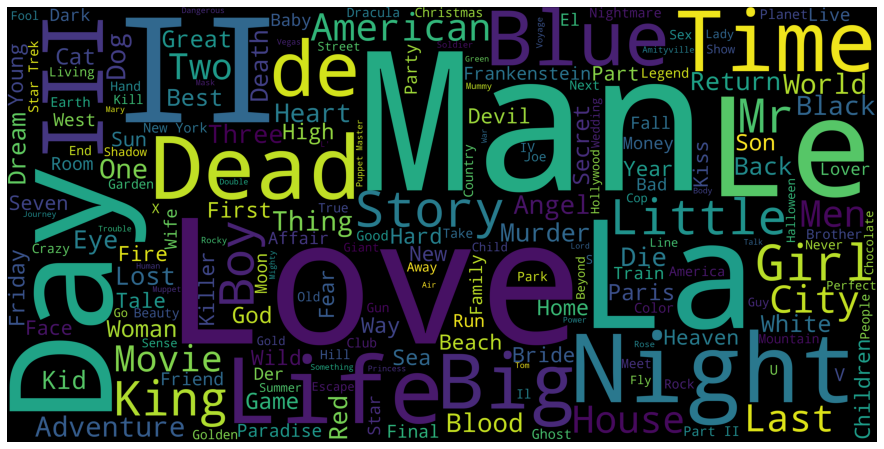

In [14]:
plt.figure(figsize=(16, 8))
plt.imshow(title_wordcloud)
plt.axis("off")
plt.show()

### Ratings

In [15]:
ratings["rating"].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [16]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

In [17]:
cuentas = ratings["rating"].value_counts()

/home/jorge/micromamba/envs/mc_reco/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

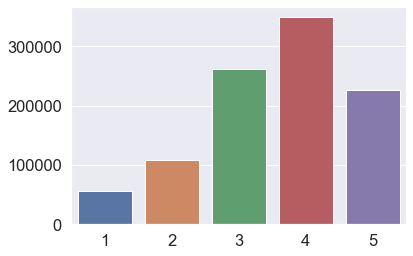

In [18]:
sns.barplot(cuentas.index, cuentas.values)

/home/jorge/micromamba/envs/mc_reco/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

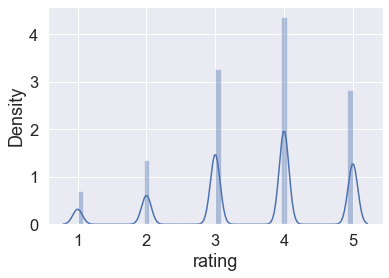

In [19]:
sns.distplot(ratings["rating"])

### Géneros

Al estar separados por `|` tendremos que hacer un procesamiento:

In [20]:
from functools import reduce

In [21]:
genre_labels = reduce(
    lambda x, y: np.union1d(x, y), movies["genres"].str.split("|").values
)

In [22]:
genre_labels

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype='<U11')

In [23]:
len(genre_labels)

18

Ahora contamos cuantos hay de cada:

In [24]:
unique, counts = np.unique(
    np.concatenate(movies["genres"].str.split("|").values), return_counts=True
)

In [25]:
keyword_occurences = dict(zip(unique, counts))

In [26]:
keyword_occurences

{'Action': 503,
 'Adventure': 283,
 'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Crime': 211,
 'Documentary': 127,
 'Drama': 1603,
 'Fantasy': 68,
 'Film-Noir': 44,
 'Horror': 343,
 'Musical': 114,
 'Mystery': 106,
 'Romance': 471,
 'Sci-Fi': 276,
 'Thriller': 492,
 'War': 143,
 'Western': 68}

In [27]:
pd.Series(keyword_occurences).sort_values(ascending=False)

Drama          1603
Comedy         1200
Action          503
Thriller        492
Romance         471
Horror          343
Adventure       283
Sci-Fi          276
Children's      251
Crime           211
War             143
Documentary     127
Musical         114
Mystery         106
Animation       105
Western          68
Fantasy          68
Film-Noir        44
dtype: int64

Y pintamos en otroa nube:

In [28]:
# Create the wordcloud
genre_wordcloud = WordCloud(width=800, height=300, background_color="white")
genre_wordcloud.generate_from_frequencies(keyword_occurences)

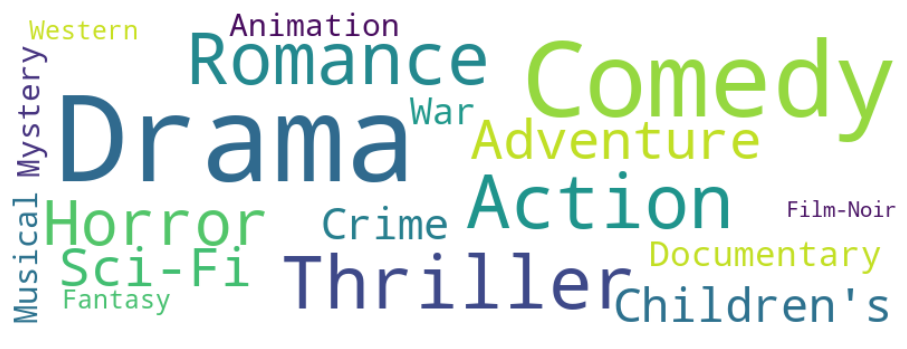

In [29]:
# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Recomendación basada en contenidos

![rec-systems](../img/rec-systems.png)

Vamos a utilizar los géneros de las películas param montar un sistema muy básico de comparación de contenidos, para ello usaremos la métrica de TF-IDF y la [distancia coseno](https://en.wikipedia.org/wiki/Cosine_similarity).




TF-IDF | Distancia Coseno
- | - 
![tfidf](../img/tfidf.jpg) | ![vector-space](../img/vector_space.png)

In [30]:
movies.genres = movies.genres.str.replace("-", "").str.replace("'", "")

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.
Usaremos el módulo `TfidfVectorizer` del paquete [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tf = TfidfVectorizer(analyzer="word", min_df=1).fit(movies.genres)

In [33]:
tf.vocabulary_

{'animation': 2,
 'childrens': 3,
 'comedy': 4,
 'adventure': 1,
 'fantasy': 8,
 'romance': 13,
 'drama': 7,
 'action': 0,
 'crime': 5,
 'thriller': 15,
 'horror': 10,
 'scifi': 14,
 'documentary': 6,
 'war': 16,
 'musical': 11,
 'mystery': 12,
 'filmnoir': 9,
 'western': 17}

In [34]:
tfidf_matrix = tf.transform(movies.genres)

In [35]:
tfidf_matrix

<3883x18 sparse matrix of type '<class 'numpy.float64'>'
	with 6408 stored elements in Compressed Sparse Row format>

In [36]:
tfidf_matrix.shape

(3883, 18)

In [37]:
movies.genres[0]

'Animation|Childrens|Comedy'

In [38]:
tfidf_matrix[0, :].toarray()

array([[0.        , 0.        , 0.72890105, 0.59171433, 0.34435072,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [41]:
cosine_sim[:4, :4]

array([[1.        , 0.30552517, 0.19737232, 0.26019351],
       [0.30552517, 1.        , 0.        , 0.        ],
       [0.19737232, 0.        , 1.        , 0.43309256],
       [0.26019351, 0.        , 0.43309256, 1.        ]])

Creamos ahora una función para recomendar nuevos contenidos:

In [42]:
titles = movies["title"]
indices = pd.Series(movies.index, index=movies["title"])


def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Vamos algunos ejemplos para ver qué tal funciona:

In [43]:
genre_recommendations("Good Will Hunting (1997)").head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [44]:
genre_recommendations("Toy Story (1995)").head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          Winnie the Pooh and the Blustery Day (1968)
1012          

In [45]:
genre_recommendations("Saving Private Ryan (1998)").head(20)

461                 Heaven & Earth (1993)
1204             Full Metal Jacket (1987)
1214          Boat, The (Das Boot) (1981)
1222                         Glory (1989)
1545                     G.I. Jane (1997)
1959           Saving Private Ryan (1998)
2358            Thin Red Line, The (1998)
2993              Longest Day, The (1962)
3559                 Flying Tigers (1942)
3574         Fighting Seabees, The (1944)
3585         Guns of Navarone, The (1961)
3684                  Patriot, The (2000)
2333    Rambo: First Blood Part II (1985)
2335                     Rambo III (1988)
2407              Heartbreak Ridge (1986)
2746                    Iron Eagle (1986)
2747                 Iron Eagle II (1988)
2748          Aces: Iron Eagle III (1992)
2749                 Iron Eagle IV (1995)
2875              Dirty Dozen, The (1967)
Name: title, dtype: object

Podemos ver como las recomendaciones no son malas pero tienen mucho margen de mejora. Esto se debe a que la información de géneros es demasiado general para conseguir una recomendación más fina.

## Ejercicio

IMDB  permite descargar parte de sus datos desde la siguiente web: https://www.imdb.com/interfaces/

Aqui podemos descargar varios dataset sobre información de los contenidos, nosotros vamos  a usar:

* https://datasets.imdbws.com/title.basics.tsv.gz
* https://datasets.imdbws.com/title.ratings.tsv.gz

Queremos utilizar la información de *keywords* por ejemplo: https://www.imdb.com/title/tt0372784/keywords para montar un sistemas de recomendación basado en esta información.

Por desgracia la información de keywords no se puede descargar de manera masiva para todos... Así que vamos a montar un script para descargar algunos:

In [46]:
imdb_basics = pd.read_csv("../datos/title.basics.tsv.gz", sep="\t")

In [47]:
imdb_basics.groupby("titleType").tconst.count()

titleType
movie            514707
short            672235
tvEpisode       3965089
tvMiniSeries      25351
tvMovie          126187
tvSeries         161862
tvShort            9122
tvSpecial         16922
video            225986
videoGame         23220
Name: tconst, dtype: int64

In [48]:
imdb_basics_pelis = imdb_basics[imdb_basics.titleType == "movie"]

In [49]:
imdb_ratings = pd.read_csv("../datos/title.ratings.tsv.gz", sep="\t")

In [50]:
len(imdb_ratings)

919026

In [51]:
imdb_ratings = imdb_ratings.merge(imdb_basics_pelis[["tconst"]], on="tconst")

In [52]:
len(imdb_ratings)

232148

In [53]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000009,5.6,76
1,tt0000147,5.2,289
2,tt0000335,6.3,39
3,tt0000574,6.2,502
4,tt0000615,4.8,14


In [54]:
imdb_ratings.describe()

,averageRating,numVotes
count,232148.000000,2.321480e+05
mean,6.230263,3.187348e+03
std,1.342845,2.988972e+04
min,1.000000,5.000000e+00
25%,5.400000,1.400000e+01
50%,6.400000,4.500000e+01
75%,7.100000,2.440000e+02
max,10.000000,2.066646e+06


/home/jorge/micromamba/envs/mc_reco/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='averageRating', ylabel='Density'>

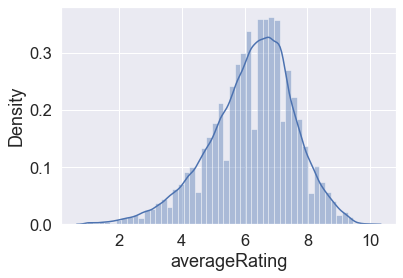

In [55]:
sns.distplot(imdb_ratings["averageRating"])

In [56]:
ids_quiero = imdb_ratings.tconst.values[
    (imdb_ratings.averageRating >= 8) & (imdb_ratings.numVotes >= 770)
]

In [57]:
len(ids_quiero)

1733

In [58]:
import requests
from bs4 import BeautifulSoup

In [59]:
def descargar_keywords(x):

    doc = requests.get("https://www.imdb.com/title/{}/keywords".format(x))

    soup = BeautifulSoup(doc.content, "lxml")

    titulo = soup.select_one('meta[name="title"]')["content"].replace(" - IMDb", "")

    keywords = np.array(
        [i.text for i in soup.select("#keywords_content table .sodatext a")]
    )

    return {"idImdb": x, "titulo": titulo, "keywords": keywords}

In [60]:
descargar_keywords(ids_quiero[1000])

{'idImdb': 'tt0338013',
 'titulo': '¡Olvídate de mí! (2004)',
 'keywords': array(['memory', 'loneliness', "valentine's day", 'flashback',
        'nonlinear timeline', 'erased memory', 'beach',
        'retrograde narrative', 'surrealism',
        'friedrich nietzsche quotation', 'induced amnesia',
        'walking on a beach in winter', 'bathing in a sink',
        'playing against type', 'reference to alexander pope',
        'angry ex girlfriend', 'suffocation',
        'reference to showtime at the apollo',
        'reference to row row row your boat',
        'reference to my darling clementine',
        'reference to huckleberry hound', 'montauk long island new york',
        'deja vu', 'male rear nudity', 'montauk new york',
        'manic pixie dream girl', 'tragicomedy', 'frozen lake', 'cleavage',
        'thong panties', 'black panties', 'blonde', 'lift skirt',
        'upskirt', 'pink panties',
        'british actor playing american character', 'star gazing', 'snow',
      

In [6]:
keywords_df = pd.read_json("../datos/imdb_example_keywords.json")

In [7]:
len(keywords_df)

1502

In [8]:
keywords_df[keywords_df.titulo.str.lower().str.contains("ryan")]

,idImdb,keywords,titulo
761,tt0120815,"[rescue mission, d day, world war two, normand...",Salvar al soldado Ryan (1998)


In [22]:
keywords_df

,idImdb,keywords,titulo
0,tt0006864,"[multiple storyline, babylon babylonia, paris ...",Intolerancia (1916)
1,tt0010323,"[somnambulist, expressionism, hypnosis, avant ...",El gabinete del Dr. Caligari (1920)
2,tt0012349,"[lucifer morningstar character, the little tra...",El chico (1921)
3,tt0012364,"[ghost story, ghost, salvation, alcoholic, tub...",La carreta fantasma (1921)
4,tt0013442,"[vampire, self sacrifice, bite mark, dracula, ...",Nosferatu (1922)
...,...,...,...
1497,tt8760684,"[apollo 11, neil armstrong, buzz aldrin, astro...",Apollo 11 (2019)
1498,tt9124428,"[horse, race, love, success, turkey, hope, can...",Bizim Için Sampiyon (2018)
1499,tt9135854,"[football, barcelona fc, reference to pep guar...","Take the ball, pass the ball (Toca y pasa el b..."
1500,tt9151704,"[korean boy band, pool party, testimonial, con...",Burn The Stage. The movie (2018)


Se pide:
* Repetir el ejercicio hecho pero con el dataset descargado de IMDB
* Jugar con las opciones de `TfidfVectorizer` (por ejemplo `ngram`, `min_df`...) para crear un vocabulario adecuado

In [11]:
from functools import reduce

In [53]:
keywords_df['keywords_str'] = keywords_df.keywords.apply(lambda keywords: ' '.join(keywords))
keywords_df

,idImdb,keywords,titulo,keywords_str
0,tt0006864,"[multiple storyline, babylon babylonia, paris ...",Intolerancia (1916),multiple storyline babylon babylonia paris fra...
1,tt0010323,"[somnambulist, expressionism, hypnosis, avant ...",El gabinete del Dr. Caligari (1920),somnambulist expressionism hypnosis avant gard...
2,tt0012349,"[lucifer morningstar character, the little tra...",El chico (1921),lucifer morningstar character the little tramp...
3,tt0012364,"[ghost story, ghost, salvation, alcoholic, tub...",La carreta fantasma (1921),ghost story ghost salvation alcoholic tubercul...
4,tt0013442,"[vampire, self sacrifice, bite mark, dracula, ...",Nosferatu (1922),vampire self sacrifice bite mark dracula gothi...
...,...,...,...,...
1497,tt8760684,"[apollo 11, neil armstrong, buzz aldrin, astro...",Apollo 11 (2019),apollo 11 neil armstrong buzz aldrin astronaut...
1498,tt9124428,"[horse, race, love, success, turkey, hope, can...",Bizim Için Sampiyon (2018),horse race love success turkey hope cancer
1499,tt9135854,"[football, barcelona fc, reference to pep guar...","Take the ball, pass the ball (Toca y pasa el b...",football barcelona fc reference to pep guardio...
1500,tt9151704,"[korean boy band, pool party, testimonial, con...",Burn The Stage. The movie (2018),korean boy band pool party testimonial concert...


In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
tf = TfidfVectorizer(analyzer="word", min_df=1).fit(keywords_df.keywords_str)

In [96]:
tf.vocabulary_

{'multiple': 9824,
 'storyline': 14181,
 'babylon': 1253,
 'babylonia': 1254,
 'paris': 10716,
 'france': 5943,
 'jerusalem': 7923,
 'time': 14965,
 'frames': 5940,
 'national': 9945,
 'film': 5629,
 'registry': 12104,
 'deception': 4045,
 'intolerance': 7746,
 'huguenot': 7265,
 'medicis': 9277,
 'wedding': 16070,
 'protestant': 11642,
 'mill': 9453,
 'marriage': 9100,
 'judea': 8017,
 'reformer': 12079,
 'massacre': 9156,
 'epic': 5143,
 'saved': 12783,
 'from': 6024,
 'hanging': 6751,
 'naivety': 9905,
 'hypocrisy': 7351,
 '6th': 284,
 'century': 2711,
 '16th': 42,
 'actor': 416,
 'playing': 11207,
 'roles': 12469,
 'usurper': 15623,
 'trial': 15247,
 'treachery': 15218,
 'sword': 14530,
 'fight': 5612,
 'suicide': 14350,
 'spinster': 13870,
 'self': 13037,
 'sacrifice': 12634,
 'royalty': 12552,
 'robbery': 12433,
 'remorse': 12158,
 'religious': 12137,
 'persecution': 10934,
 'rehabilitation': 12109,
 'priest': 11509,
 'prayer': 11435,
 'police': 11280,
 'murder': 9836,
 'miracle'

In [97]:
dict(sorted(tf.vocabulary_.items(), key=lambda item: item[1]))

{'007': 0,
 '08': 1,
 '10': 2,
 '100': 3,
 '1000': 4,
 '100s': 5,
 '108': 6,
 '109': 7,
 '11': 8,
 '1160s': 9,
 '1170s': 10,
 '1180s': 11,
 '1183': 12,
 '1190s': 13,
 '1191': 14,
 '11th': 15,
 '12': 16,
 '120': 17,
 '12th': 18,
 '13': 19,
 '130': 20,
 '1300s': 21,
 '13th': 22,
 '14': 23,
 '1400s': 24,
 '1410s': 25,
 '1420s': 26,
 '14th': 27,
 '15': 28,
 '150': 29,
 '1500s': 30,
 '1550s': 31,
 '1560s': 32,
 '1570s': 33,
 '1586': 34,
 '15th': 35,
 '16': 36,
 '1600s': 37,
 '1630': 38,
 '1680s': 39,
 '1686': 40,
 '16mm': 41,
 '16th': 42,
 '17': 43,
 '1700s': 44,
 '1701': 45,
 '1710s': 46,
 '1725': 47,
 '1740s': 48,
 '1760s': 49,
 '1770s': 50,
 '1780s': 51,
 '178th': 52,
 '1790s': 53,
 '17th': 54,
 '18': 55,
 '1800s': 56,
 '1810s': 57,
 '1820s': 58,
 '1830s': 59,
 '1838': 60,
 '1840s': 61,
 '1850s': 62,
 '1858': 63,
 '1859': 64,
 '1860': 65,
 '1860s': 66,
 '1861': 67,
 '1862': 68,
 '1863': 69,
 '1868': 70,
 '1870': 71,
 '1870s': 72,
 '1871': 73,
 '1880s': 74,
 '1881': 75,
 '1886': 76,
 '188

In [82]:
tf2 = TfidfVectorizer(analyzer="word", ngram_range=(1,2)).fit(keywords_df.keywords_str)

In [83]:
tf2.vocabulary_

{'multiple': 91910,
 'storyline': 134247,
 'babylon': 10437,
 'babylonia': 10439,
 'paris': 100813,
 'france': 56954,
 'jerusalem': 75830,
 'time': 141714,
 'frames': 56942,
 'national': 93587,
 'film': 53212,
 'registry': 113448,
 'deception': 38983,
 'intolerance': 74089,
 'huguenot': 69819,
 'medicis': 87329,
 'wedding': 153768,
 'protestant': 109818,
 'mill': 88736,
 'marriage': 85935,
 'judea': 76591,
 'reformer': 113333,
 'massacre': 86575,
 'epic': 47648,
 'saved': 120819,
 'from': 58046,
 'hanging': 64949,
 'naivety': 93183,
 'hypocrisy': 70559,
 '6th': 1434,
 'century': 25018,
 '16th': 115,
 'actor': 2551,
 'playing': 105116,
 'roles': 118406,
 'usurper': 149480,
 'trial': 146346,
 'treachery': 146069,
 'sword': 137163,
 'fight': 52749,
 'suicide': 135417,
 'spinster': 131603,
 'self': 123153,
 'sacrifice': 119850,
 'royalty': 119198,
 'robbery': 117970,
 'remorse': 115325,
 'religious': 115182,
 'persecution': 102556,
 'rehabilitation': 113571,
 'priest': 108060,
 'prayer': 1

In [84]:
dict(sorted(tf2.vocabulary_.items(), key=lambda item: item[1]))

{'007': 0,
 '007 banker': 1,
 '08': 2,
 '08 panic': 3,
 '10': 4,
 '10 year': 5,
 '10 years': 6,
 '100': 7,
 '100 honda': 8,
 '1000': 9,
 '1000 battle': 10,
 '1000 nationalism': 11,
 '100s': 12,
 '100s assassination': 13,
 '108': 14,
 '108 year': 15,
 '109': 16,
 '109 supermarine': 17,
 '11': 18,
 '11 2001': 19,
 '11 abduction': 20,
 '11 attack': 21,
 '11 neil': 22,
 '11 patriot': 23,
 '11 space': 24,
 '11 year': 25,
 '1160s': 26,
 '1160s pope': 27,
 '1170s': 28,
 '1170s 1160s': 29,
 '1180s': 30,
 '1180s king': 31,
 '1183': 32,
 '1183 1180s': 33,
 '1190s': 34,
 '1190s treason': 35,
 '1191': 36,
 '1191 rope': 37,
 '11th': 38,
 '11th century': 39,
 '11th grade': 40,
 '12': 41,
 '12 chapters': 42,
 '12 colt': 43,
 '12 remington': 44,
 '12 year': 45,
 '120': 46,
 '120 jaguar': 47,
 '12th': 48,
 '12th century': 49,
 '13': 50,
 '13 open': 51,
 '13 year': 52,
 '130': 53,
 '130 hercules': 54,
 '1300s': 55,
 '1300s epic': 56,
 '1300s tavern': 57,
 '13th': 58,
 '13th century': 59,
 '13th man': 60

In [98]:
tfidf_matrix = tf.transform(keywords_df.keywords_str)
tfidf_matrix_2 = tf2.transform(keywords_df.keywords_str)

In [99]:
tfidf_matrix

<1502x16491 sparse matrix of type '<class 'numpy.float64'>'
	with 167863 stored elements in Compressed Sparse Row format>

In [104]:
tfidf_matrix_2

<1502x158325 sparse matrix of type '<class 'numpy.float64'>'
	with 385750 stored elements in Compressed Sparse Row format>

In [100]:
print(f"shape tfidf_matrix: {tfidf_matrix.shape}")
print(f"shape tfidf_matrix_2: {tfidf_matrix_2.shape}")

shape tfidf_matrix: (1502, 16491)
shape tfidf_matrix_2: (1502, 158325)


(1502, 158325)

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_2 = cosine_similarity(tfidf_matrix_2, tfidf_matrix_2)


In [90]:
cosine_sim_2[:4, :4]

array([[1.        , 0.01488674, 0.01556784, 0.00920333],
       [0.01488674, 1.        , 0.01278548, 0.05611138],
       [0.01556784, 0.01278548, 1.        , 0.01341234],
       [0.00920333, 0.05611138, 0.01341234, 1.        ]])

In [106]:
titles = keywords_df["titulo"]
indices = pd.Series(keywords_df.index, index=keywords_df["titulo"])

def keywords_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [114]:
print(f"cosine_sim:\n{keywords_recommendations('Batman Begins (2005)', cosine_sim).head(10)}")
print(f"\ncosine_sim_2:\n{keywords_recommendations('Batman Begins (2005)', cosine_sim_2).head(10)}")

cosine_sim:
1191    El caballero oscuro: La leyenda renace (2012)
1081                       El caballero oscuro (2008)
1365                                     Logan (2017)
1300                                The Raid 2 (2014)
1196                                    Origen (2010)
1401                  Vengadores: Infinity War (2018)
1203                                  Deadpool (2016)
1048                               Infiltrados (2006)
1197            Mad Max: Furia en la carretera (2015)
726                     Sospechosos habituales (1995)
Name: titulo, dtype: object

cosine_sim_2:
1191    El caballero oscuro: La leyenda renace (2012)
1081                       El caballero oscuro (2008)
1365                                     Logan (2017)
1300                                The Raid 2 (2014)
1401                  Vengadores: Infinity War (2018)
1203                                  Deadpool (2016)
1196                                    Origen (2010)
584                        

In [115]:
print(f"cosine_sim:\n{keywords_recommendations('El padrino (1972)', cosine_sim).head(10)}")
print(f"\ncosine_sim_2:\n{keywords_recommendations('El padrino (1972)', cosine_sim_2).head(10)}")

cosine_sim:
437       El padrino: Parte II (1974)
652        Uno de los nuestros (1990)
1300                The Raid 2 (2014)
703      El profesional (Léon) (1994)
617                    Nayakan (1987)
1048               Infiltrados (2006)
752          L.A. Confidential (1997)
568        El precio del poder (1983)
726     Sospechosos habituales (1995)
964             Ciudad de Dios (2002)
Name: titulo, dtype: object

cosine_sim_2:
1300                     The Raid 2 (2014)
437            El padrino: Parte II (1974)
652             Uno de los nuestros (1990)
703           El profesional (Léon) (1994)
1365                          Logan (2017)
1044    Sin City: Ciudad del pecado (2005)
1048                    Infiltrados (2006)
761          Salvar al soldado Ryan (1998)
964                  Ciudad de Dios (2002)
1227                    El renacido (2015)
Name: titulo, dtype: object
